In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/SolarEnergy/SolarPrediction.csv


# HI-SEAS Solar Irradiance Prediction

## Dataset
Taken from Space Apps 2017's "You are my sunshine" challenge, this dataset contains meteorological data from the HI-SEAS habitat in Hawaii. The features that have been recorded are:
* Solar Irradiance (W/m2)
* Temperature (°F)
* Barometric Pressure (Hg)
* Humidity (%)
* Wind Direction (°)
* Wind Speed (mph)
* Sun Rise/Set Time

## Import the required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow import keras

## Obtaining the dataset

In [3]:
dataset = pd.read_csv('/kaggle/input/SolarEnergy/SolarPrediction.csv')
dataset = dataset.sort_values(['UNIXTime'], ascending = True)
dataset.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
7416,1472724008,9/1/2016 12:00:00 AM,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00
7415,1472724310,9/1/2016 12:00:00 AM,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00
7414,1472725206,9/1/2016 12:00:00 AM,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00
7413,1472725505,9/1/2016 12:00:00 AM,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00
7412,1472725809,9/1/2016 12:00:00 AM,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00


In [4]:
dataset.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


In [5]:
dataset.shape

(32686, 11)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32686 entries, 7416 to 24522
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 3.0+ MB


## Feature Engineering
As we observe, some columns like Date, Time, TimeSunRise, TimeSunSet, etc. are not useful until refined further.

In [7]:
from datetime import datetime
from pytz import timezone
import pytz
hawaii= timezone('Pacific/Honolulu')
dataset.index =  pd.to_datetime(dataset['UNIXTime'], unit='s')
dataset.index = dataset.index.tz_localize(pytz.utc).tz_convert(hawaii)
dataset['MonthOfYear'] = dataset.index.strftime('%m').astype(int)
dataset['DayOfYear'] = dataset.index.strftime('%j').astype(int)
dataset['WeekOfYear'] = dataset.index.strftime('%U').astype(int)
dataset['TimeOfDay(h)'] = dataset.index.hour
dataset['TimeOfDay(m)'] = dataset.index.hour*60 + dataset.index.minute
dataset['TimeOfDay(s)'] = dataset.index.hour*60*60 + dataset.index.minute*60 + dataset.index.second
dataset['TimeSunRise'] = pd.to_datetime(dataset['TimeSunRise'], format='%H:%M:%S')
dataset['TimeSunSet'] = pd.to_datetime(dataset['TimeSunSet'], format='%H:%M:%S')
dataset['DayLength(s)'] = dataset['TimeSunSet'].dt.hour*60*60 \
                           + dataset['TimeSunSet'].dt.minute*60 \
                           + dataset['TimeSunSet'].dt.second \
                           - dataset['TimeSunRise'].dt.hour*60*60 \
                           - dataset['TimeSunRise'].dt.minute*60 \
                           - dataset['TimeSunRise'].dt.second
dataset.drop(['Data','Time','TimeSunRise','TimeSunSet'], inplace=True, axis=1)
dataset.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,MonthOfYear,DayOfYear,WeekOfYear,TimeOfDay(h),TimeOfDay(m),TimeOfDay(s),DayLength(s)
UNIXTime,,,,,,,,,,,,,,
2016-09-01 00:00:08-10:00,1472724008,2.58,51,30.43,103,77.27,11.25,9,245,35,0,0,8,45060
2016-09-01 00:05:10-10:00,1472724310,2.83,51,30.43,103,153.44,9.00,9,245,35,0,5,310,45060
2016-09-01 00:20:06-10:00,1472725206,2.16,51,30.43,103,142.04,7.87,9,245,35,0,20,1206,45060
2016-09-01 00:25:05-10:00,1472725505,2.21,51,30.43,103,144.12,18.00,9,245,35,0,25,1505,45060
2016-09-01 00:30:09-10:00,1472725809,2.25,51,30.43,103,67.42,11.25,9,245,35,0,30,1809,45060


## Feature Visualization
Next, we visualize the time means of the various features

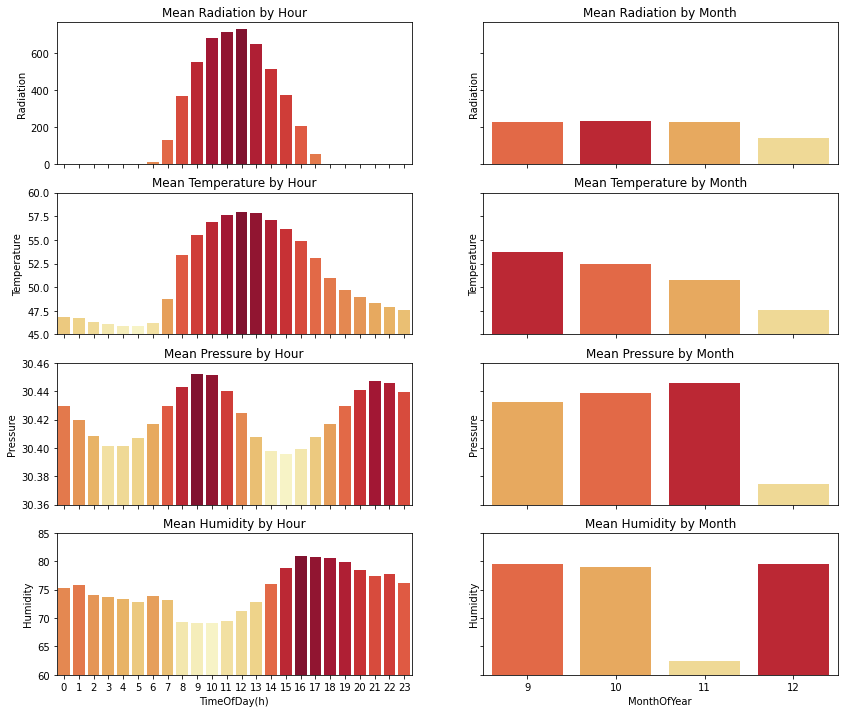

In [8]:
grouped_m=dataset.groupby('MonthOfYear').mean().reset_index()
grouped_w=dataset.groupby('WeekOfYear').mean().reset_index()
grouped_d=dataset.groupby('DayOfYear').mean().reset_index()
grouped_h=dataset.groupby('TimeOfDay(h)').mean().reset_index()

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, sharex='col', sharey='row', figsize=(14,12))
ax3.set_ylim(45,60)
ax5.set_ylim(30.36,30.46)
ax7.set_ylim(60,85)

ax1.set_title('Mean Radiation by Hour')
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Radiation'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Radiation', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax1)
ax1.set_xlabel('')

ax2.set_title('Mean Radiation by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Radiation'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Radiation', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax2)
ax2.set_xlabel('')

ax3.set_title('Mean Temperature by Hour')
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Temperature'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Temperature', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax3)
ax3.set_xlabel('')

ax4.set_title('Mean Temperature by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Temperature'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Temperature', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax4)
ax4.set_xlabel('')

ax5.set_title('Mean Pressure by Hour')
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Pressure'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Pressure', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax5)
ax5.set_xlabel('')

ax6.set_title('Mean Pressure by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Pressure'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Pressure', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax6)
ax6.set_xlabel('')

ax7.set_title('Mean Humidity by Hour')
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Humidity'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Humidity', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax7)

ax8.set_title('Mean Humidity by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Humidity'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Humidity', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax8)

plt.show()

From the above plots, its clear that temperature has strong corellation with solar irradiance. Relationships between pressure/humidity and solar irradiance are less clear but it does appear that humidity has a negative correlation with solar irradiance, temperature and pressure.

As expected solar irradiance and temperature both peak at approximately 12:00. Additionally, monthly means of both solar irradiance and temperature appear to decrease as winter approaches, with the exception of a very slight increase in solar irradiance from September to October.

## Pearson Correlation
To further help visualise any realtionships between the variables, a pearson correlation heatmap was plotted.

From the plots in the previous section it is clear that solar irradiance does not have a linear correlation with time of day. Therefore, despite the strong realtionship between the two, 'TimeOfDay' columns were excluded from the heatmap. 'UNIXTime', 'MonthOfYear' and 'WeekOfYear' were also excluded because it is likely to more useful to use a combination of 'TimeOfDay' and 'DayOfYear' in training and prediction.

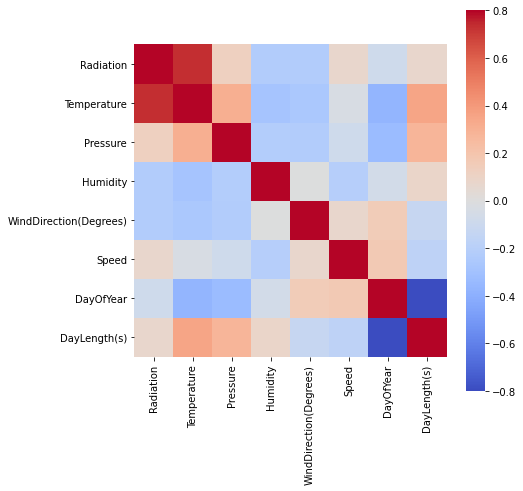

In [9]:
corrmat = dataset.drop(['TimeOfDay(h)', 'TimeOfDay(m)', 'TimeOfDay(s)', 'UNIXTime', 'MonthOfYear', 'WeekOfYear'], inplace=False, axis=1)
corrmat = corrmat.corr()
f, ax = plt.subplots(figsize=(7,7))
sns.heatmap(corrmat, vmin=-.8, vmax=.8, square=True, cmap = 'coolwarm')
plt.show()

## Separating the target variable 

In [10]:
X = dataset[['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'DayOfYear', 'TimeOfDay(s)']]
y = dataset['Radiation']

## Splitting the dataset 
We split the dataset into train and test set with an 80-20 split

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test_full, y_train, y_test_full = train_test_split(X, y, test_size = 0.7, random_state = 0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test_full, y_test_full, test_size = 0.5, random_state = 0)

## Declaring our Model architecture

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32686, 6)          42        
_________________________________________________________________
dense_1 (Dense)              (None, 32686, 50)         350       
_________________________________________________________________
dense_2 (Dense)              (None, 32686, 100)        5100      
_________________________________________________________________
dense_3 (Dense)              (None, 32686, 50)         5050      
_________________________________________________________________
dense_4 (Dense)              (None, 32686, 1)          51        
Total params: 10,593
Trainable params: 10,593
Non-trainable params: 0
_________________________________________________________________


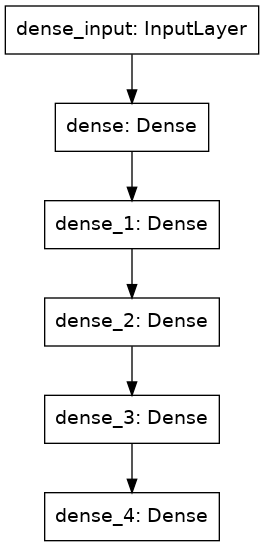

In [12]:
model = keras.models.Sequential([keras.layers.Dense(6, activation = "relu", input_shape = [32686, 6]),
                                 keras.layers.Dense(50, activation = "relu"),
                                 keras.layers.Dense(100, activation = "relu"),
                                 keras.layers.Dense(50, activation = "relu"),
                                 keras.layers.Dense(1, activation = "linear")])

model.summary()
keras.utils.plot_model(model)

## Weights and biases

In [13]:
# accessing a layer from the model
model.layers
hidden1 = model.layers[1]
hidden1.name

# accessing the parameters of a layer from the model i.e. weights and biases
weights, biases = hidden1.get_weights()
print(weights, weights.shape)

print(biases, biases.shape)
# One bias term for every neuron in the layer

# Weights and biases are initialized when we declare the input size. If no input size is declared then Keras waits till it receives the input

[[ 0.2395925  -0.3249842   0.10682264  0.17477489 -0.12277192  0.17575914
  -0.06368995 -0.21091501  0.277992    0.16519785 -0.07160291  0.14549795
  -0.14981976 -0.08226608 -0.23342112  0.27700073 -0.1987728   0.14955965
  -0.30357254 -0.0159786   0.23520929  0.17853165 -0.3188651   0.24012023
   0.039942    0.32429332  0.19961363  0.29290098 -0.30750167  0.15274996
  -0.15300663  0.10308158 -0.31353024  0.05539313  0.22016126 -0.00890437
   0.10828403 -0.21095325  0.18847936 -0.31543124 -0.05983552  0.01096091
   0.02269831 -0.13206095  0.12401035  0.28376245  0.08611327 -0.05405644
   0.11271814  0.21793813]
 [-0.04886565  0.2289995   0.22969043 -0.2967222  -0.3111655  -0.2629075
   0.11435443  0.30306315 -0.06851226  0.30984217 -0.15128052  0.32021952
  -0.06757349 -0.2379528   0.301746   -0.1278554  -0.21097659  0.20670354
  -0.16358905 -0.02801111  0.06239441 -0.17568389 -0.075847    0.17248875
   0.31551898  0.12740207 -0.07889713 -0.20313005 -0.16900718  0.2854079
  -0.03550559

## Compiling our model

In [14]:
model.compile(loss = "mse",
              optimizer = keras.optimizers.Adam(learning_rate = 0.01))
# We have sparse categories i.e. our labels are single integers from 0-9 hence this loss. If we had vector labels i.e. [00100..] to signify
# the third category then we would use "categorical_crossentropy"
# If it was binary classification then our activation function would have been sigmoid instead of softmax with loss as "binary_crossentropy"

# sgd signifies simple Stochastic Gradient Descent

## Training and evaluating the model

In [15]:
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))

Epoch 1/50
307/307 [==============================] - 2s 5ms/step - loss: 745348.5471 - val_loss: 113206.2344
Epoch 2/50
307/307 [==============================] - 1s 2ms/step - loss: 114927.3745 - val_loss: 110867.4375
Epoch 3/50
307/307 [==============================] - 1s 3ms/step - loss: 114610.0885 - val_loss: 106093.6641
Epoch 4/50
307/307 [==============================] - 1s 3ms/step - loss: 101162.9578 - val_loss: 52116.1016
Epoch 5/50
307/307 [==============================] - 1s 3ms/step - loss: 62131.9966 - val_loss: 102127.8203
Epoch 6/50
307/307 [==============================] - 1s 3ms/step - loss: 64423.8139 - val_loss: 82302.4062
Epoch 7/50
307/307 [==============================] - 1s 3ms/step - loss: 51392.1435 - val_loss: 33553.4766
Epoch 8/50
307/307 [==============================] - 1s 2ms/step - loss: 50670.7943 - val_loss: 36005.0859
Epoch 9/50
307/307 [==============================] - 1s 2ms/step - loss: 32394.0700 - val_loss: 29697.1465
Epoch 10/50
307/307 

## Plotting our metrics : Loss, accuracy

<function matplotlib.pyplot.show(close=None, block=None)>

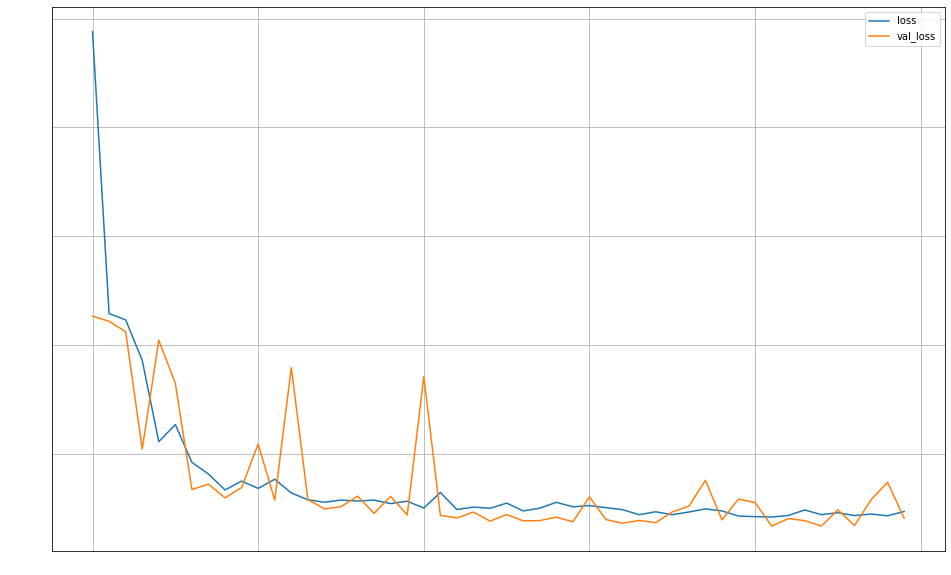

In [16]:
pd.DataFrame(history.history).plot(figsize = (16, 10))
plt.tick_params(colors = 'w')
plt.grid(True)
plt.show

## Testing and predictions

In [17]:
model.evaluate(X_test, y_test)

y_pred = model.predict(X_test[:10])
y_pred

358/358 [==============================] - 0s 894us/step - loss: 20300.0078


array([[ 85.51365  ],
       [  4.270893 ],
       [ 11.9175205],
       [ 62.53991  ],
       [ 11.9175205],
       [ 11.9175205],
       [  4.651635 ],
       [409.51855  ],
       [ 11.9175205],
       [  2.5731678]], dtype=float32)

In [18]:
y_test[:10]

UNIXTime
2016-11-28 07:15:24-10:00    32.99
2016-12-27 04:40:55-10:00     1.22
2016-11-06 23:00:02-10:00     1.24
2016-09-03 06:30:08-10:00    16.21
2016-09-06 23:20:18-10:00     2.49
2016-09-01 20:20:06-10:00     2.15
2016-09-15 04:40:07-10:00     1.22
2016-12-01 11:40:02-10:00    24.75
2016-09-22 19:20:24-10:00     1.24
2016-11-22 02:15:01-10:00     1.20
Name: Radiation, dtype: float64